# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

## Libraries and Dependencies

In [72]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [73]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [74]:
print(device)

cpu


## Physics-informed Neural Networks

In [75]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [79]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X, u, layers, lb, ub):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # settings
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        self.dnn.register_parameter('lambda_2', self.lambda_2)
        
         # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        # self.optimizer_sgd = torch.optim.SGD(
        #     self.dnn.parameters(), 
        #     lr=1.0, 
        #     max_iter=50000, 
        #     max_eval=50000, 
        #     history_size=50,
        #     tolerance_grad=1e-5, 
        #     tolerance_change=1.0 * np.finfo(float).eps,
        #     line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        # )
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=1.0)
        self.optimizer_LBFGS = torch.optim.LBFGS(self.dnn.parameters())
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Loss: %e, l1: %.5f, l2: %.5f' % 
                (
                    loss.item(), 
                    self.lambda_1.item(), 
                    torch.exp(self.lambda_2.detach()).item()
                )
            )
        return loss
    
    def train(self, nIter, method="Adam"):
        self.dnn.train()
        loss_residual = []
        for epoch in range(nIter):
            u_pred = self.net_u(self.x, self.t)
            f_pred = self.net_f(self.x, self.t)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            loss_residual.append(loss.item())

            # Backward and optimize
            if method == "Adam":
                self.optimizer_Adam.zero_grad()
                loss.backward()
                self.optimizer_Adam.step()
            if method == "LBFGS":
                self.optimizer_LBFGS.zero_grad()
                loss.backward()
                self.optimizer_LBFGS.step(self.loss_func)
            if method == "SGD":
                self.optimizer_SGD.zero_grad()
                loss.backward()
                self.optimizer_SGD.step(self.loss_func)
            
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f' % 
                    (
                        epoch, 
                        loss.item(), 
                        self.lambda_1.item(), 
                        torch.exp(self.lambda_2).item()
                    )
                )
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
        return loss_residual
    
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

## Configurations

In [80]:
nu = 0.01/np.pi

N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

## Training on Non-noisy Data

In [94]:
%%time

noise = 0.0            

# create training set
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
%timeit ad = model.train(500)

It: 0, Loss: 3.967e-01, Lambda_1: -0.001, Lambda_2: 0.002479
It: 100, Loss: 7.620e-02, Lambda_1: 0.034, Lambda_2: 0.002170
It: 200, Loss: 3.402e-02, Lambda_1: 0.065, Lambda_2: 0.002043
It: 300, Loss: 2.915e-02, Lambda_1: 0.093, Lambda_2: 0.002077
It: 400, Loss: 2.613e-02, Lambda_1: 0.136, Lambda_2: 0.002085
Loss: 8.624096e-03, l1: 0.64936, l2: 0.00375
Loss: 4.095960e-03, l1: 0.76906, l2: 0.00452
Loss: 2.441791e-03, l1: 0.88186, l2: 0.00520
Loss: 1.554627e-03, l1: 0.92390, l2: 0.00550
Loss: 8.765856e-04, l1: 0.96942, l2: 0.00529
Loss: 4.937911e-04, l1: 0.97875, l2: 0.00496
Loss: 3.743242e-04, l1: 0.99197, l2: 0.00473
Loss: 2.897097e-04, l1: 0.97759, l2: 0.00436
Loss: 2.329366e-04, l1: 0.97945, l2: 0.00410
Loss: 1.948254e-04, l1: 0.98937, l2: 0.00396
Loss: 1.622700e-04, l1: 0.98901, l2: 0.00378
Loss: 1.329639e-04, l1: 0.99106, l2: 0.00357
Loss: 1.137801e-04, l1: 0.99143, l2: 0.00349
Loss: 1.027529e-04, l1: 0.99105, l2: 0.00341
Loss: 9.044011e-05, l1: 0.99538, l2: 0.00338
Loss: 8.072266e-

In [95]:
# model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
# sgd = model.train(200, method="SGD")

In [ ]:

model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
%timeit lbfgs = model.train(500, method="LBFGS")

Loss: 2.364146e-02, l1: 0.25407, l2: 0.00245
Loss: 1.620137e-02, l1: 0.43634, l2: 0.00251
Loss: 1.138117e-02, l1: 0.56432, l2: 0.00261
Loss: 6.971826e-03, l1: 0.63874, l2: 0.00279
Loss: 4.818140e-03, l1: 0.73343, l2: 0.00291
Loss: 3.477842e-03, l1: 0.81651, l2: 0.00316
Loss: 2.683691e-03, l1: 0.86619, l2: 0.00333
Loss: 2.048659e-03, l1: 0.88823, l2: 0.00346
Loss: 1.631589e-03, l1: 0.91217, l2: 0.00350
Loss: 1.266118e-03, l1: 0.94213, l2: 0.00351
Loss: 9.698082e-04, l1: 0.94242, l2: 0.00342
Loss: 8.017441e-04, l1: 0.94817, l2: 0.00336
Loss: 6.585292e-04, l1: 0.95790, l2: 0.00331
Loss: 5.400351e-04, l1: 0.95877, l2: 0.00334
Loss: 4.405068e-04, l1: 0.96513, l2: 0.00337
Loss: 3.693312e-04, l1: 0.97827, l2: 0.00338
Loss: 3.132096e-04, l1: 0.97962, l2: 0.00341
Loss: 2.875477e-04, l1: 0.98879, l2: 0.00341
Loss: 2.426931e-04, l1: 0.98642, l2: 0.00340
Loss: 2.116744e-04, l1: 0.98749, l2: 0.00338
Loss: 1.824506e-04, l1: 0.99321, l2: 0.00335
Loss: 1.622466e-04, l1: 0.99461, l2: 0.00332
Loss: 1.44

In [ ]:
# evaluations
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model.lambda_1.detach().cpu().numpy()
lambda_2_value = model.lambda_2.detach().cpu().numpy()
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  

Error u: 2.488054e-03
Error l1: 0.14228%
Error l2: 0.51013%


## Training on Noisy Data

In [ ]:
# noise = 0.01    

# # create training set
# u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

# # training
# model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
# model.train(500)            

## Visualizations

In [ ]:
def myplot(x, y, xlab, ylab, xscale="linear", yscale="log"):
    plt.figure(figsize=(10, 8))
    plt.xscale(xscale)
    plt.yscale(yscale)
    for key in y:
        plt.plot(x[key], y[key], label=key)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(loc="best", fontsize=24)
    plt.xlabel(xlab, fontsize=24)
    plt.ylabel(ylab, fontsize=24)

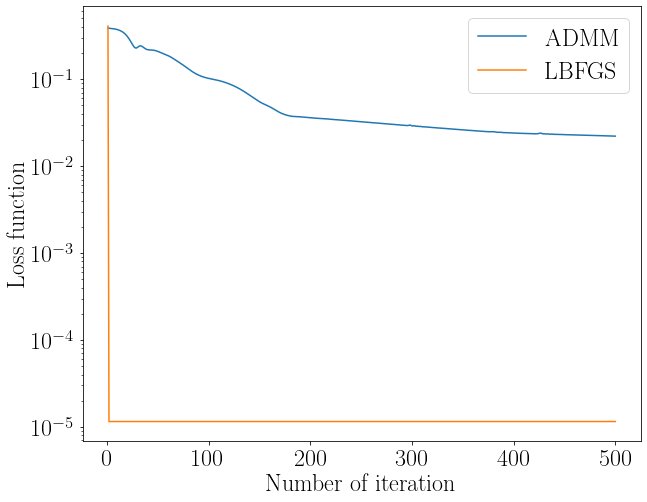

In [96]:

import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
myplot({"ADMM": range(1, len(ad) + 1), "LBFGS": range(1, len(lbfgs) + 1)},
       {"ADMM": ad, "LBFGS": lbfgs}, "Number of iteration",
       r"Loss function")

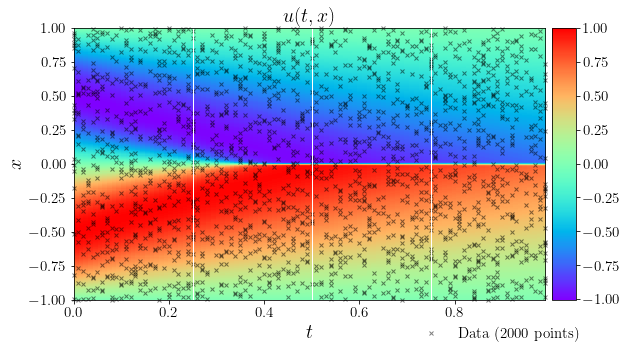

In [ ]:

""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=.5
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

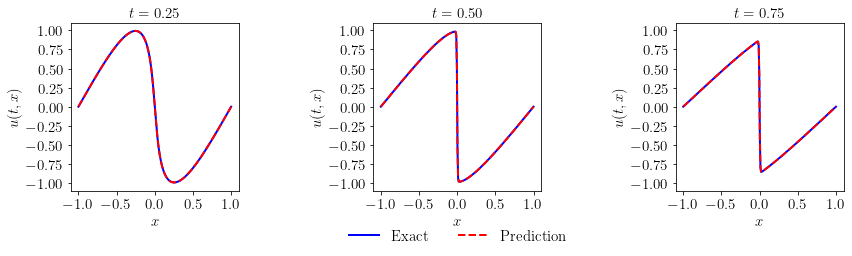

In [ ]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

In [ ]:
# evaluations
u_pred, f_pred = model.predict(X_star)

lambda_1_value_noisy = model.lambda_1.detach().cpu().numpy()
lambda_2_value_noisy = model.lambda_2.detach().cpu().numpy()
lambda_2_value_noisy = np.exp(lambda_2_value_noisy)

error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0) * 100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1_noisy))                             
print('Error l2: %.5f%%' % (error_lambda_2_noisy))    

Error u: 2.361779e-03
Error l1: 0.00888%
Error l2: 0.03116%


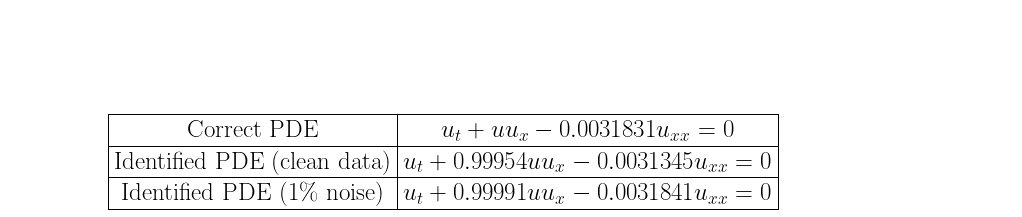

In [ ]:
####### Row 3: Identified PDE ##################    

fig = plt.figure(figsize=(14, 10))

gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=0.25, bottom=0, left=0.0, right=1.0, wspace=0.0)

ax = plt.subplot(gs2[:, :])
ax.axis('off')

s1 = r'$\begin{tabular}{ |c|c| }  \hline Correct PDE & $u_t + u u_x - 0.0031831 u_{xx} = 0$ \\  \hline Identified PDE (clean data) & '
s2 = r'$u_t + %.5f u u_x - %.7f u_{xx} = 0$ \\  \hline ' % (lambda_1_value, lambda_2_value)
s3 = r'Identified PDE (1\% noise) & '
s4 = r'$u_t + %.5f u u_x - %.7f u_{xx} = 0$  \\  \hline ' % (lambda_1_value_noisy, lambda_2_value_noisy)
s5 = r'\end{tabular}$'
s = s1+s2+s3+s4+s5
ax.text(0.1, 0.1, s, size=25)

plt.show()